##### Copyright &copy; 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TFX – tf.Transorm (Audio)

This notebook demonstrates how to use tf.Transform in your TFX pipeline for audio datasets. In this lab, we will be using the **NSynth** dataset, which is a collection of different musical tones, in order to analyze our data, create Mel Spectrograms for visual data, and run the data through our pipeline. 

Here is a list of what we will be doing in this lab: 


1.   Download and analyze the NSynth dataset
2.   Create a Mel Spectrogram from our data
3.   Run the pipeline interactively


## Setup
First, we install the necessary packages, download data, import modules and set up paths.

In [ ]:
!pip install tfx
!pip install tensorflow_datasets==2.1.0
!pip install librosa
!pip install apache-beam
!pip install tensorflow_data_validation

## Did you restart the runtime?

If you are using Google Colab, the first time that you run the cell above, you must restart the runtime (Runtime > Restart runtime ...). This is because of the way that Colab loads packages.

### Import packages
We import necessary packages, including standard TFX component classes.

In [1]:
import apache_beam as beam
import librosa.display
import librosa as lr
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import tempfile
import tensorflow as tf
import tensorflow_data_validation as tfdv
import tensorflow_datasets as tfds
import tfx
import unittest
import urllib
import warnings

from IPython.display import Audio
from tensorflow_metadata.proto.v0 import schema_pb2
from tfx.components.example_gen.import_example_gen.component import ImportExampleGen
from tfx.components.example_validator.component import ExampleValidator
from tfx.components.schema_gen.component import SchemaGen
from tfx.components.statistics_gen.component import StatisticsGen
from tfx.components.transform.component import Transform
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.proto import example_gen_pb2
#from tfx.utils.dsl_utils import external_input

Set up various parameters that we will be using later on in the lab.

In [2]:
COLOR = 'orange'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

keras = tf.keras
K = keras.backend

warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

Check the versions of TensorFlow and TFX.

In [3]:
print('TensorFlow version: {}'.format(tf.__version__))
print('TFX version: {}'.format(tfx.__version__))

TensorFlow version: 2.5.1
TFX version: 1.2.0


### Download example data
 We use TFDS to load the *NSynth* dataset

In [4]:
test_dataset, dataset_info = tfds.load(name="nsynth/full",
                               split="test",
                               try_gcs=True,
                               with_info=True)

We can view more information about our dataset in this cell below. There are several different features in the dataset below that this dataset contains. We will be *selecting* audio samples from the data's **id** feature, however it is worth noting the other features within the data. 

In [5]:
dataset_info

tfds.core.DatasetInfo(
    name='nsynth',
    version=2.3.0,
    description='The NSynth Dataset is an audio dataset containing ~300k musical notes, each
with a unique pitch, timbre, and envelope. Each note is annotated with three
additional pieces of information based on a combination of human evaluation
and heuristic algorithms: Source, Family, and Qualities.
',
    homepage='https://g.co/magenta/nsynth-dataset',
    features=FeaturesDict({
        'audio': Tensor(shape=(64000,), dtype=tf.float32),
        'id': tf.string,
        'instrument': FeaturesDict({
            'family': ClassLabel(shape=(), dtype=tf.int64, num_classes=11),
            'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=1006),
            'source': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
        }),
        'pitch': ClassLabel(shape=(), dtype=tf.int64, num_classes=128),
        'qualities': FeaturesDict({
            'bright': tf.bool,
            'dark': tf.bool,
            'distortion'

The sample rate refers to the number of audio samples recorded per second (measured in Hz). We will set a static value for our sample rate, which will be used to visualize and analyze our data later on.

In [6]:
SAMPLE_RATE = 16000

For the sakes of this lab, we will only grab a batch of 32 audio samples. This is simply because of repetition of different musical pitches that are differentiated by timbre.

In [7]:
test_dataset = test_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [8]:
# Get the first batch
batch = next(iter(test_dataset))
audio = batch['audio']

Pick a sample in the batch (ID between 0 and 31 inclusive). When you have finished this lab, rerun this cell and the rest of the lab to see how different audio samples look different on the Mel Spectrogram.

In [10]:
ID = 17
Audio(audio[ID].numpy(), rate=SAMPLE_RATE)

## Making audio useful with the Mel Spectrogram

Now that we know what the NSynth Data looks like, we can now create a Mel Spectrogram to visualize and analyze the audio. A *Spectrogram* is a visual that displays various signals (such as audio signals). The *Mel scale* is a scale consisting of pitches with equal distance in between each pitch (such as the pitches on each key of a piano). As a result, the mel scale allows us to understand how we are able to differentiate musical tones. Altogether, a **Mel Spectrogram** is a spectrogram that has been convereted from the frequency scale to the mel scale. 

In order to create our wn Mel Spectrogram, we will follow this process:


1.   Compute the Short-Time Fourier Transform of the audio signal
2.   Discard phase and keep magnitude  
3.   Instantiate the mel filterbank  
4.   Warp the linear-scale magnitude-spectrograms to mel-scale  
5.   Transform magnitudes to log-scale  



In [11]:
FFT_SIZE = 1024
HOP_SIZE = 512
N_MEL_BINS = 64
N_SPECTROGRAM_BINS = (FFT_SIZE // 2) + 1
F_MIN = 0.0
F_MAX = SAMPLE_RATE / 2

Compute STFT

In [12]:
spectrograms = tf.signal.stft(audio, 
                              frame_length=FFT_SIZE, 
                              frame_step=HOP_SIZE)

Compute magnitude

In [13]:
magnitude_spectrograms = tf.abs(spectrograms)

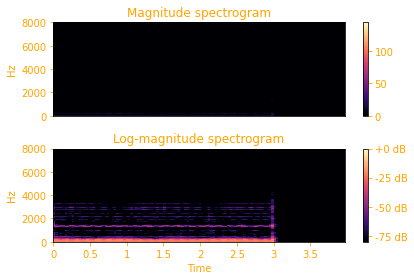

In [14]:
# https://librosa.github.io/librosa/generated/librosa.core.power_to_db.html

S = magnitude_spectrograms[ID].numpy().T

plt.figure()
plt.subplot(2, 1, 1)
lr.display.specshow(S, sr=SAMPLE_RATE, y_axis='linear')
plt.colorbar()
plt.title('Magnitude spectrogram')

plt.subplot(2, 1, 2)
lr.display.specshow(lr.amplitude_to_db(S, ref=np.max),
                    y_axis='linear', x_axis='time', sr=SAMPLE_RATE, 
                    hop_length=HOP_SIZE)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-magnitude spectrogram')
plt.tight_layout()

Text(0.5, 1.0, 'Log-magnitude spectrogram')

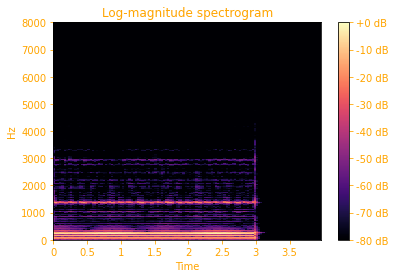

In [15]:
lr.display.specshow(lr.amplitude_to_db(S, ref=np.max), 
                    y_axis='linear', x_axis='time', sr=SAMPLE_RATE, 
                    hop_length=HOP_SIZE)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-magnitude spectrogram')

Initialize mel filterbank

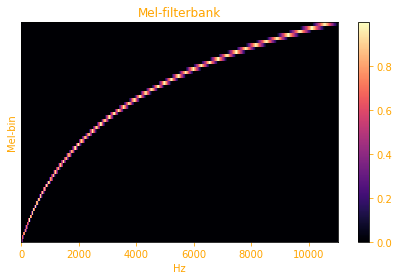

In [16]:
mel_filterbank = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=N_MEL_BINS,
    num_spectrogram_bins=N_SPECTROGRAM_BINS,
    sample_rate=SAMPLE_RATE,
    lower_edge_hertz=F_MIN,
    upper_edge_hertz=F_MAX)


plt.figure()
lr.display.specshow(mel_filterbank.numpy().T, x_axis='linear')
plt.ylabel('Mel-bin')
plt.title('Mel-filterbank')
plt.colorbar()
plt.tight_layout()

Warp the magnitude spectrograms to mel scale

In [15]:
mel_power_spectrograms = tf.matmul(tf.square(magnitude_spectrograms),
                                   mel_filterbank)

Transform magnitudes to log-scale

In [16]:
def power_to_db(S, amin=1e-16, top_db=80.0):
    """Convert a power-spectrogram (magnitude squared) to decibel (dB) units.
    Based on:
    https://librosa.github.io/librosa/generated/librosa.core.power_to_db.html
    """
    def _tf_log10(x):
        numerator = tf.math.log(x)
        denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
        return numerator / denominator
    
    # Scale magnitude relative to maximum value in S. 
    # Zeros in the output corresponding to positions where S == ref.
    ref = tf.reduce_max(S)

    log_spec = 10.0 * _tf_log10(tf.maximum(amin, S))
    log_spec -= 10.0 * _tf_log10(tf.maximum(amin, ref))

    log_spec = tf.maximum(log_spec, tf.reduce_max(log_spec) - top_db)

    return log_spec

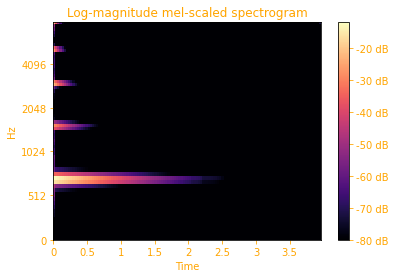

In [17]:
log_magnitude_mel_spectrograms = power_to_db(mel_power_spectrograms)

lr.display.specshow(log_magnitude_mel_spectrograms[ID].numpy().T, 
                    y_axis='mel', x_axis='time', sr=SAMPLE_RATE, 
                    hop_length=HOP_SIZE)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-magnitude mel-scaled spectrogram')
_ = plt.savefig('melspec.png', dpi=300)

## Running the pipeline interactively

In [18]:
context = InteractiveContext()

In [19]:
import IPython.display as display
import pprint 

HOME = 'gs://tfds-data'
examples_path = os.path.join(HOME, "datasets", "nsynth/full", str(dataset_info.version))

In [20]:
#examples = external_input(examples_path)

In [21]:
input_config = example_gen_pb2.Input(splits=[
    example_gen_pb2.Input.Split(name='test', pattern='nsynth-test.tfrecord-00000-of-00008')])
example_gen = ImportExampleGen(input_base=examples_path, input_config=input_config)

context.run(example_gen)

Connecting anonymously.


ExecutionResult(
    component_id: ImportExampleGen
    execution_id: 1
    outputs:
        examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 1
        type_id: 14
        uri: "/tmp/tfx-interactive-2021-08-25T16_02_18.187323-xrjjgsd0/ImportExampleGen/examples/1"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "file_format"
          value {
            string_value: "tfrecords_gzip"
          }
        }
        custom_properties {
          key: "input_fingerprint"
          value {
            string_value: "split:test,num_files:1,total_bytes:131330657,xor_checksum:1578453206,sum_checksum:1578453206"
          }
        }
        custom_properties {
          key: "payload_format"
          value {
            string_value: "FORMAT_TF_EXAMPLE"
          }
        }
        custom_properties {
          key: "span"
          value {
            int_value: 0
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.2.0"
          }
        }
        state: LIVE
        , artifact_type: id: 14
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [22]:
# Computes statistics over data for visualization and example validation.
statistics_gen = StatisticsGen(
    examples=example_gen.outputs['examples'])
context.run(statistics_gen)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 2
    outputs:
        statistics: Channel(
            type_name: ExampleStatistics
            artifacts: [Artifact(artifact: id: 2
        type_id: 16
        uri: "/tmp/tfx-interactive-2021-08-25T16_02_18.187323-xrjjgsd0/StatisticsGen/statistics/2"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "statistics"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "StatisticsGen"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.2.0"
          }
        }
        state: LIVE
        , artifact_type: id: 16
        name: "ExampleStatistics"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [23]:
# Generates schema based on statistics files.
infer_schema = SchemaGen(statistics=statistics_gen.outputs['statistics'], infer_feature_shape=True)
context.run(infer_schema)

ExecutionResult(
    component_id: SchemaGen
    execution_id: 3
    outputs:
        schema: Channel(
            type_name: Schema
            artifacts: [Artifact(artifact: id: 3
        type_id: 18
        uri: "/tmp/tfx-interactive-2021-08-25T16_02_18.187323-xrjjgsd0/SchemaGen/schema/3"
        custom_properties {
          key: "name"
          value {
            string_value: "schema"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "SchemaGen"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.2.0"
          }
        }
        state: LIVE
        , artifact_type: id: 18
        name: "Schema"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [24]:
train_uri = infer_schema.outputs['schema'].get()[0].uri
schema_filename = os.path.join(train_uri, "schema.pbtxt")
schema = tfx.utils.io_utils.parse_pbtxt_file(file_name=schema_filename,
                                             message=schema_pb2.Schema())

In [25]:
tfdv.display_schema(schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'audio',FLOAT,required,,-
'id',BYTES,required,,-
'instrument/family',INT,required,,-
'instrument/label',INT,required,,-
'instrument/source',INT,required,,-
'pitch',INT,required,,-
'qualities/bright',INT,required,,-
'qualities/dark',INT,required,,-
'qualities/distortion',INT,required,,-


In [26]:
# Performs anomaly detection based on statistics and data schema.
validate_stats = ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=infer_schema.outputs['schema'])
context.run(validate_stats)

ExecutionResult(
    component_id: ExampleValidator
    execution_id: 4
    outputs:
        anomalies: Channel(
            type_name: ExampleAnomalies
            artifacts: [Artifact(artifact: id: 4
        type_id: 20
        uri: "/tmp/tfx-interactive-2021-08-25T16_02_18.187323-xrjjgsd0/ExampleValidator/anomalies/4"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "anomalies"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "ExampleValidator"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.2.0"
          }
        }
        state: LIVE
        , artifact_type: id: 20
        name: "ExampleAnomalies"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [27]:
# Set up paths.
_transform_module_file = 'nsynth_transform.py'

In [28]:
%%writefile {_transform_module_file}

import tensorflow_transform as tft
import tensorflow as tf


SAMPLE_RATE = 16000
FFT_SIZE = 1024
HOP_SIZE = 512
N_MEL_BINS = 64
N_SPECTROGRAM_BINS = (FFT_SIZE // 2) + 1
F_MIN = 0.0
F_MAX = SAMPLE_RATE / 2

def _transformed_name(name):
  return name + '_xf'


def _tf_log10(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator

def power_to_db(magnitude, amin=1e-16, top_db=80.0):
    """
    https://librosa.github.io/librosa/generated/librosa.core.power_to_db.html
    """
    ref_value = tf.reduce_max(magnitude)
    log_spec = 10.0 * _tf_log10(tf.maximum(amin, magnitude))
    log_spec -= 10.0 * _tf_log10(tf.maximum(amin, ref_value))
    log_spec = tf.maximum(log_spec, tf.reduce_max(log_spec) - top_db)

    return log_spec

def get_mel_spectrogram(waveforms):
    mel_filterbank = tf.signal.linear_to_mel_weight_matrix(
              num_mel_bins=N_MEL_BINS,
              num_spectrogram_bins=FFT_SIZE // 2 + 1,
              sample_rate=SAMPLE_RATE,
              lower_edge_hertz=F_MIN,
              upper_edge_hertz=F_MAX)
    
    spectrograms = tf.signal.stft(waveforms,
                                  frame_length=FFT_SIZE,
                                  frame_step=HOP_SIZE,
                                  pad_end=False)

    magnitude_spectrograms = tf.abs(spectrograms)
    mel_spectrograms = tf.matmul(tf.square(magnitude_spectrograms),
                                  mel_filterbank)
    log_mel_spectrograms = power_to_db(mel_spectrograms)
    log_mel_spectrograms = tf.expand_dims(log_mel_spectrograms, 3)
    return log_mel_spectrograms

def preprocessing_fn(inputs):
  """tf.transform's callback function for preprocessing inputs.

  Args:
    inputs: map from feature keys to raw not-yet-transformed features.

  Returns:
    Map from string feature key to transformed feature operations.
  """
  outputs = {}

  AUDIO_KEY = 'audio'
  AUDIO = inputs.pop(AUDIO_KEY)
  outputs[_transformed_name(AUDIO_KEY)] = get_mel_spectrogram(AUDIO)

  for feature, value in inputs.items():
    outputs[_transformed_name(feature)] = value
  return outputs

Writing nsynth_transform.py


In [29]:
# Performs transformations and feature engineering in training and serving.
transform = Transform(
    examples=example_gen.outputs['examples'],
    schema=infer_schema.outputs['schema'],
    module_file=os.path.abspath(_transform_module_file))
context.run(transform)

Instructions for updating:
Use ref() instead.


Instructions for updating:
Use ref() instead.


INFO:tensorflow:Assets written to: /tmp/tfx-interactive-2021-08-25T16_02_18.187323-xrjjgsd0/Transform/transform_graph/5/.temp_path/tftransform_tmp/500e36d4f0b04005b686cbc99b241c90/assets


INFO:tensorflow:Assets written to: /tmp/tfx-interactive-2021-08-25T16_02_18.187323-xrjjgsd0/Transform/transform_graph/5/.temp_path/tftransform_tmp/500e36d4f0b04005b686cbc99b241c90/assets


ExecutionResult(
    component_id: Transform
    execution_id: 5
    outputs:
        transform_graph: Channel(
            type_name: TransformGraph
            artifacts: [Artifact(artifact: id: 5
        type_id: 22
        uri: "/tmp/tfx-interactive-2021-08-25T16_02_18.187323-xrjjgsd0/Transform/transform_graph/5"
        custom_properties {
          key: "name"
          value {
            string_value: "transform_graph"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.2.0"
          }
        }
        state: LIVE
        , artifact_type: id: 22
        name: "TransformGraph"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        )
        transformed_examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 6
        type_id: 14
        uri: "/tmp/tfx-interactive-2021-08-25T16_02_18.187323-xrjjgsd0/Transform/transformed_examples/5"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "transformed_examples"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.2.0"
          }
        }
        state: LIVE
        , artifact_type: id: 14
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        )
        updated_analyzer_cache: Channel(
            type_name: TransformCache
            artifacts: [Artifact(artifact: id: 7
        type_id: 23
        uri: "/tmp/tfx-interactive-2021-08-25T16_02_18.187323-xrjjgsd0/Transform/updated_analyzer_cache/5"
        custom_properties {
          key: "name"
          value {
            string_value: "updated_analyzer_cache"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.2.0"
          }
        }
        state: LIVE
        , artifact_type: id: 23
        name: "TransformCache"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        )
        pre_transform_schema: Channel(
            type_name: Schema
            artifacts: [Artifact(artifact: id: 8
        type_id: 18
        uri: "/tmp/tfx-interactive-2021-08-25T16_02_18.187323-xrjjgsd0/Transform/pre_transform_schema/5"
        custom_properties {
          key: "name"
          value {
            string_value: "pre_transform_schema"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"


In [30]:
transform.outputs

{'transform_graph': Channel(
     type_name: TransformGraph
     artifacts: [Artifact(artifact: id: 5
 type_id: 22
 uri: "/tmp/tfx-interactive-2021-08-25T16_02_18.187323-xrjjgsd0/Transform/transform_graph/5"
 custom_properties {
   key: "name"
   value {
     string_value: "transform_graph"
   }
 }
 custom_properties {
   key: "producer_component"
   value {
     string_value: "Transform"
   }
 }
 custom_properties {
   key: "state"
   value {
     string_value: "published"
   }
 }
 custom_properties {
   key: "tfx_version"
   value {
     string_value: "1.2.0"
   }
 }
 state: LIVE
 , artifact_type: id: 22
 name: "TransformGraph"
 )]
     additional_properties: {}
     additional_custom_properties: {}
 ),
 'transformed_examples': Channel(
     type_name: Examples
     artifacts: [Artifact(artifact: id: 6
 type_id: 14
 uri: "/tmp/tfx-interactive-2021-08-25T16_02_18.187323-xrjjgsd0/Transform/transformed_examples/5"
 properties {
   key: "split_names"
   value {
     string_value: "[\"tra

In [31]:
train_uri = transform.outputs['transform_graph'].get()[0].uri
os.listdir(train_uri)

['transformed_metadata', 'transform_fn', 'metadata']

In [32]:
# Get the URI of the output artifact representing the transformed examples, which is a directory
train_uri = os.path.join(transform.outputs['transformed_examples'].get()[0].uri, 'Split-train')

# Get the list of files in this directory (all compressed TFRecord files)
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

# Create a `TFRecordDataset` to read these files
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

In [33]:
from tfx_bsl.coders import example_coder

for index, tfrecord in enumerate(dataset.take(1)):
  # Decode example
  example = example_coder.ExampleToNumpyDict(tfrecord.numpy())
  # Get mel spectrogram features (log scale)
  log_magnitude_mel_spectrograms = example['audio_xf'].reshape(124, 64)

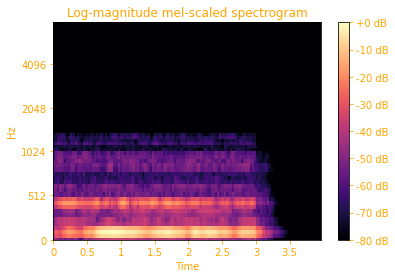

In [34]:
lr.display.specshow(log_magnitude_mel_spectrograms.T, 
                    y_axis='mel', x_axis='time', sr=SAMPLE_RATE, 
                    hop_length=HOP_SIZE)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-magnitude mel-scaled spectrogram')
_ = plt.savefig('melspec.png', dpi=300)